In [1]:
!pip install google-play-scraper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 391.6 kB/s eta 0:00:00


In [2]:
import google_play_scraper

In [3]:
app_id = 'com.facebook.katana'

In [4]:
from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import json
from time import sleep
from typing import List, Optional, Tuple

In [5]:
MAX_COUNT_EACH_FETCH = 199


class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(
        self, token, lang, country, sort, count, filter_score_with, filter_device_with
    ):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with


In [6]:
def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]

In [7]:
def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.MOST_RELEVANT,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return (
                [],
                continuation_token,
            )

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)

    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            #funnan MOD start
            token = continuation_token.token
            continue
            #MOD end

        for review in review_items:
            result.append(
                {
                    k: spec.extract_content(review)
                    for k, spec in ElementSpecs.Review.items()
                }
            )

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(
            token, lang, country, sort, count, filter_score_with, filter_device_with
        ),
    )


In [8]:
def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

In [9]:
reviews_count = 25000

In [10]:
result = []
continuation_token = None


with tqdm(total=reviews_count, position=0, leave=True) as pbar:
    while len(result) < reviews_count:
        new_result, continuation_token = reviews(
            app_id,
            continuation_token=continuation_token,
            lang='en', #The language of review
            country='in', #Country for which you want to scrape
            sort=Sort.NEWEST,
            filter_score_with=None,
            count=199 #No need to change this
        )
        if not new_result:
            break
        result.extend(new_result)
        pbar.update(len(new_result))

25074it [00:18, 1323.88it/s]                           


In [13]:
import pandas as pd

# Assuming the user wants to just display the DataFrame with styling
df = pd.DataFrame(result)

# Use the style attribute of the DataFrame to apply styling
df.head(7).style

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,73c5c741-9b1a-487d-874e-14730723fc45,Bayo Ojo,https://play-lh.googleusercontent.com/a/ACg8ocLM-np1JcUxJTqWJDNb4-3pzonXAWuh0lOLj6uUS7ex4gFDHA=mo,Pls open my box I lost it,4,0,None,2024-08-07 05:13:12,None,None,None
1,d6832124-4e37-4773-a922-5f172f0d66b4,Jerick Obra,https://play-lh.googleusercontent.com/a/ACg8ocKazSbWLNtwbn87hJ41K5EjVViznTuqJ-bY8IZNmGZg-yi3vg=mo,Maganda ako,5,0,436.0.0.35.101,2024-08-07 05:13:07,None,None,436.0.0.35.101
2,4282582d-8ef8-4b9f-8796-199a8dcfe973,RAHUL KUMAR DUTTA,https://play-lh.googleusercontent.com/a-/ALV-UjUJfLJV6pmWrRoKNufARlATZNeueyHJgYXxCIHmvG57fwDgxYfA,good,5,0,475.1.0.46.82,2024-08-07 05:13:07,None,None,475.1.0.46.82
3,b10c767e-f3a8-47b3-82e1-e50599fce99d,Eric Denaga,https://play-lh.googleusercontent.com/a/ACg8ocL-gWniLxrvNyQm-grO3ruYzsmAE8P_L9FSKS33jPiS6_PxKA=mo,This is Nice app,5,0,None,2024-08-07 05:12:33,None,None,None
4,8d517472-1158-4331-8952-dc2360d38514,Hm Jahid Bin Monir,https://play-lh.googleusercontent.com/a/ACg8ocLCeiQKuDMSv2QwGGa7Ro-GPbromjtgHXcTd7Hv95SsmIPykw=mo,Sei,5,0,None,2024-08-07 05:12:21,None,None,None
5,20aa7a48-04d1-4311-ac02-aa7197d39c75,Shoaib Baba,https://play-lh.googleusercontent.com/a/ACg8ocKPQbdFdvkSH9CSGqePyFg1YvADCtA0a0gAJjshLSB__CyNxw=mo,Best,5,0,None,2024-08-07 05:12:06,None,None,None
6,a1a41837-b09d-45f6-9dcb-e1747b9a2fe5,Rizza Llanera,https://play-lh.googleusercontent.com/a-/ALV-UjXwjRB5F9KOKnvxtG0qm6dO5KI_XyxzEHo4IcclkTKhMayEYS8,It' so nakakainis. Lahat ng account ko suspended normal account. SUSPENDED! OMG METAAAAAA!!! WALA NAMAN AKO GINAGAWA SA FB WHY SUSPENDED!!!,1,0,475.1.0.46.82,2024-08-07 05:11:26,None,None,475.1.0.46.82


In [14]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [15]:
df = df[['reviewId', 'userName', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion']]

In [16]:
import datetime

In [17]:
today = datetime.date.today()

yesterday = today - datetime.timedelta(days=1)

print(yesterday)

2024-08-07


In [20]:
df.head(6)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,73c5c741-9b1a-487d-874e-14730723fc45,Bayo Ojo,Pls open my box I lost it,4,0,None,2024-08-07 05:13:12,None
1,d6832124-4e37-4773-a922-5f172f0d66b4,Jerick Obra,Maganda ako,5,0,436.0.0.35.101,2024-08-07 05:13:07,436.0.0.35.101
2,4282582d-8ef8-4b9f-8796-199a8dcfe973,RAHUL KUMAR DUTTA,good,5,0,475.1.0.46.82,2024-08-07 05:13:07,475.1.0.46.82
3,b10c767e-f3a8-47b3-82e1-e50599fce99d,Eric Denaga,This is Nice app,5,0,None,2024-08-07 05:12:33,None
4,8d517472-1158-4331-8952-dc2360d38514,Hm Jahid Bin Monir,Sei,5,0,None,2024-08-07 05:12:21,None
5,20aa7a48-04d1-4311-ac02-aa7197d39c75,Shoaib Baba,Best,5,0,None,2024-08-07 05:12:06,None


In [21]:
df['at'].iloc[0].date()

datetime.date(2024, 8, 7)

In [22]:
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,73c5c741-9b1a-487d-874e-14730723fc45,Bayo Ojo,Pls open my box I lost it,4,0,None,2024-08-07 05:13:12,None
1,d6832124-4e37-4773-a922-5f172f0d66b4,Jerick Obra,Maganda ako,5,0,436.0.0.35.101,2024-08-07 05:13:07,436.0.0.35.101
2,4282582d-8ef8-4b9f-8796-199a8dcfe973,RAHUL KUMAR DUTTA,good,5,0,475.1.0.46.82,2024-08-07 05:13:07,475.1.0.46.82
3,b10c767e-f3a8-47b3-82e1-e50599fce99d,Eric Denaga,This is Nice app,5,0,None,2024-08-07 05:12:33,None
4,8d517472-1158-4331-8952-dc2360d38514,Hm Jahid Bin Monir,Sei,5,0,None,2024-08-07 05:12:21,None
...,...,...,...,...,...,...,...,...
25069,446dd4ab-9ded-4022-b33d-e03647e2fd93,Dagadu Mairale,YouTube,2,0,458.0.0.38.86,2024-07-29 08:19:58,458.0.0.38.86
25070,e775c005-591e-44d9-a19e-02ca58c3d2a3,General Alexis,awesome,4,0,474.0.0.52.74,2024-07-29 08:19:37,474.0.0.52.74
25071,3f3bb4f4-c501-451b-8647-93b5c69c8752,Jericho Renz Piedad,"Too many ads in a single video, so annoying.",1,0,474.0.0.52.74,2024-07-29 08:19:26,474.0.0.52.74
25072,a58fc92b-1483-4cd2-8446-2a0339c8ca9c,Regina Mansah,There some people when the send mgs and I send...,2,0,447.0.0.24.113,2024-07-29 08:19:19,447.0.0.24.113


In [23]:
new_df = df[df['at'].dt.date == yesterday]

In [24]:
new_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,73c5c741-9b1a-487d-874e-14730723fc45,Bayo Ojo,Pls open my box I lost it,4,0,None,2024-08-07 05:13:12,None
1,d6832124-4e37-4773-a922-5f172f0d66b4,Jerick Obra,Maganda ako,5,0,436.0.0.35.101,2024-08-07 05:13:07,436.0.0.35.101
2,4282582d-8ef8-4b9f-8796-199a8dcfe973,RAHUL KUMAR DUTTA,good,5,0,475.1.0.46.82,2024-08-07 05:13:07,475.1.0.46.82
3,b10c767e-f3a8-47b3-82e1-e50599fce99d,Eric Denaga,This is Nice app,5,0,None,2024-08-07 05:12:33,None
4,8d517472-1158-4331-8952-dc2360d38514,Hm Jahid Bin Monir,Sei,5,0,None,2024-08-07 05:12:21,None


In [40]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_df)

https://docs.google.com/spreadsheets/d/1EF_IktmHvrp-2KlMGwnT4A10lgQRxvB5A7nF6tZ6f9s#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


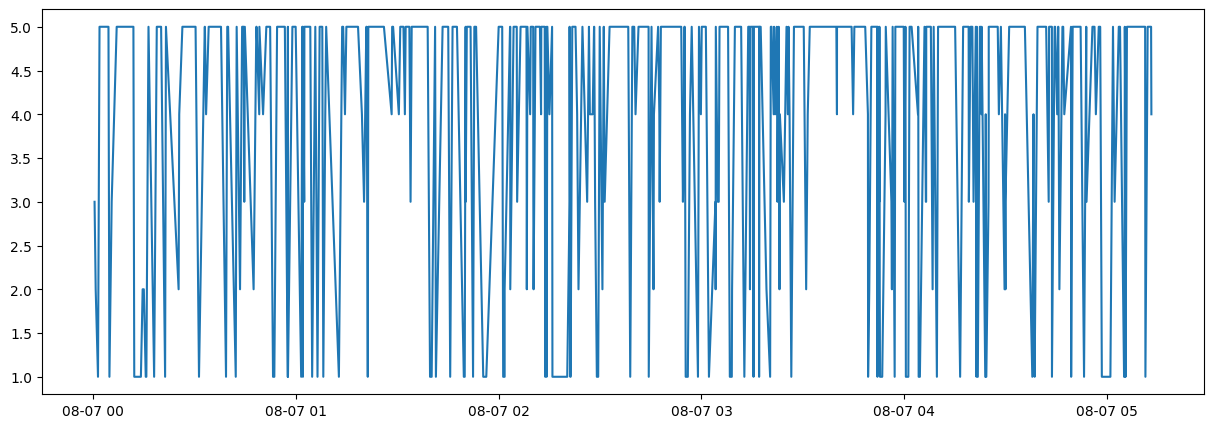

In [27]:
plt.figure(figsize = (15,5))
plt.plot(new_df['at'],new_df['score'])

([0, 1, 2, 3, 4],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

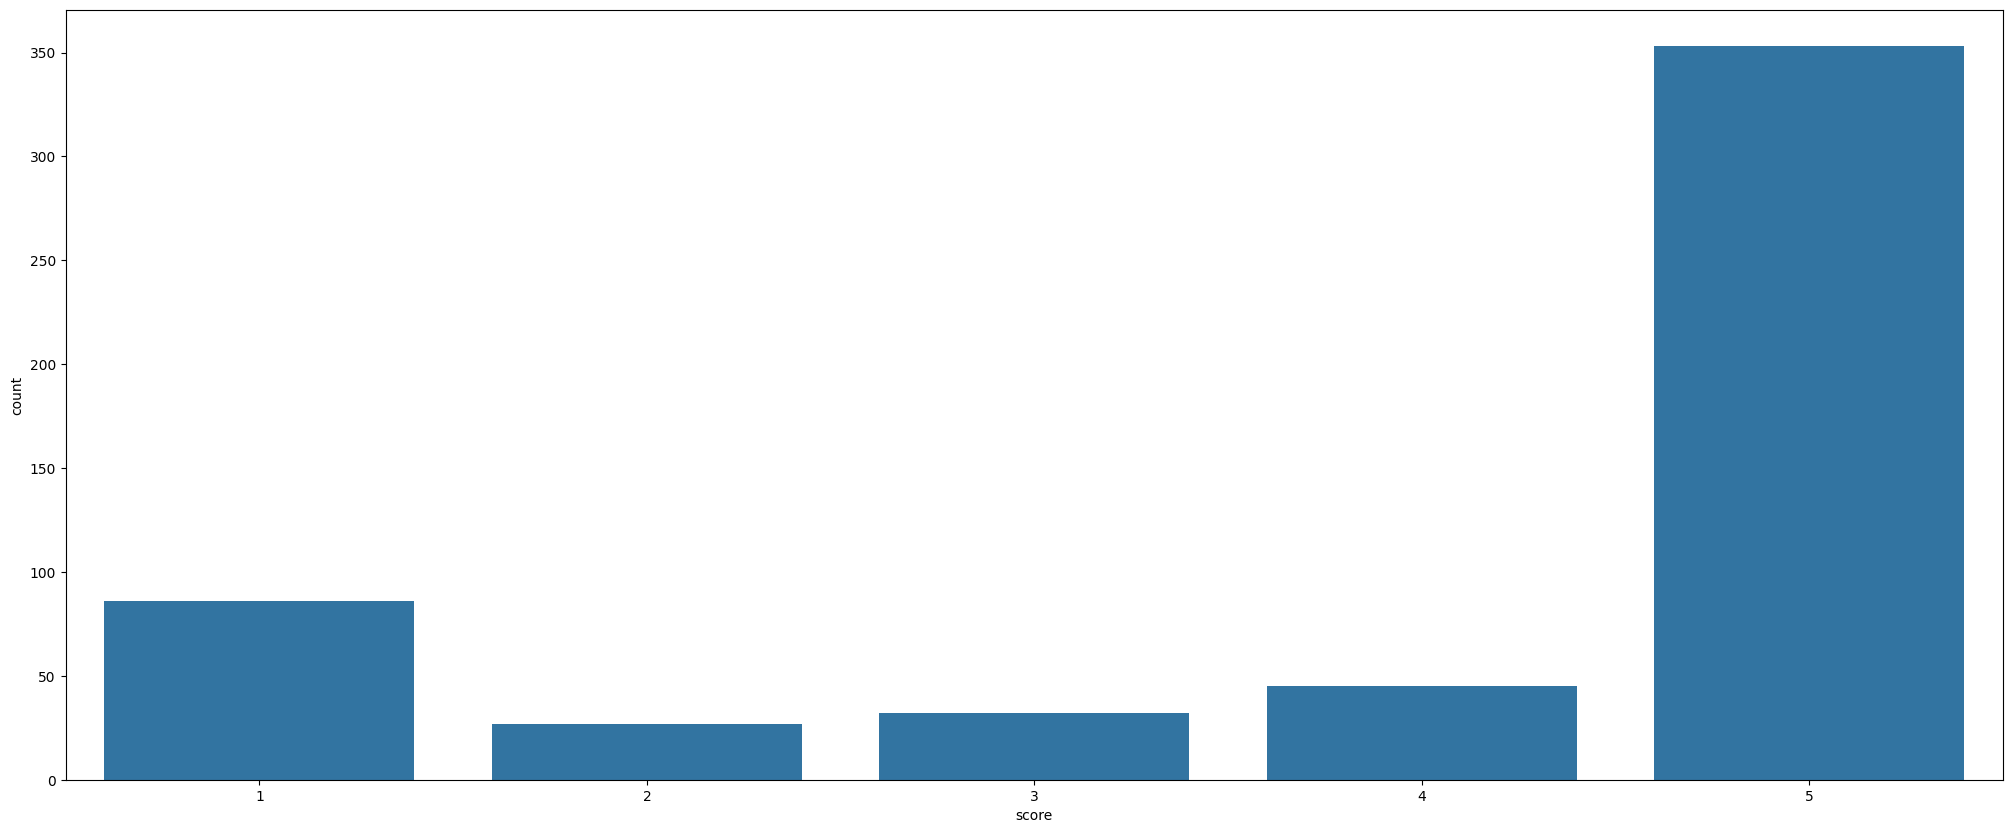

In [30]:
plt.figure(figsize = (25,10))
sns.countplot(x = 'score', data = new_df)
plt.xticks(rotation = 0)

In [8]:
# prompt: pip install pandas matplotlib fbprophet

!pip install prophet


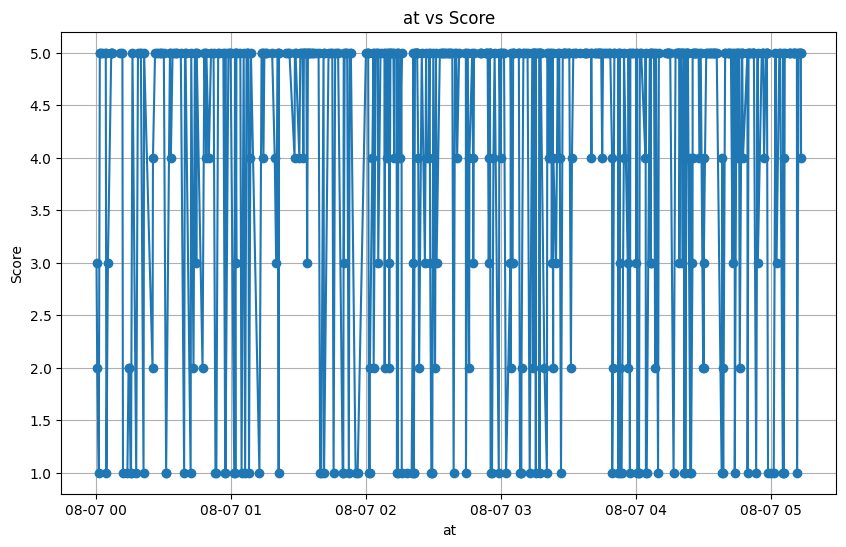

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujozrg64/aoqllczx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujozrg64/6b_r2lu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84737', 'data', 'file=/tmp/tmpujozrg64/aoqllczx.json', 'init=/tmp/tmpujozrg64/6b_r2lu1.json', 'output', 'file=/tmp/tmpujozrg64/prophet_modelay27iqse/prophet_model-20240808055823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:58:23 - cmdstanpy - INFO - Chain

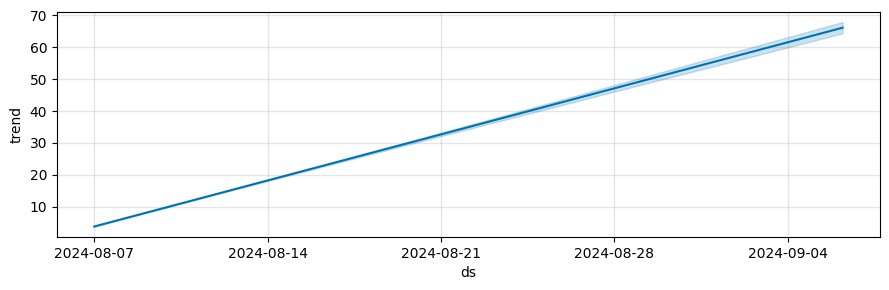

In [11]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from prophet import Prophet

# Step 1: Read and preprocess the data
data = pd.read_csv('canara a1.csv')
data['at'] = pd.to_datetime(data['at'])
data['score'] = pd.to_numeric(data['score'])

# Step 2: Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data['at'], data['score'], marker='o', linestyle='-')
plt.title('at vs Score')
plt.xlabel('at')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# Step 3: Using the Prophet model for forecasting
prophet_data = data.rename(columns={'at': 'ds', 'score': 'y'})

model = Prophet()
model.fit(prophet_data)

future = model.make_future_dataframe(periods=30)  # Extend this period as needed
forecast = model.predict(future)

# Plot the components
figure = model.plot_components(forecast)
plt.show()


In [12]:
import os

In [17]:
!mkdir my_data

In [18]:
import os
import pandas as pd

# Assuming the dataset is in the same directory as the notebook,
# adjust the path accordingly if it's located elsewhere.
dataset_path = 'canara a1.csv'  # Replace with the actual filename

if os.path.exists(dataset_path):
    dataset = pd.read_csv(dataset_path)
    dataset.info()
else:
    print(f"Error: Dataset file '{dataset_path}' not found.")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              543 non-null    object
 1   userName              543 non-null    object
 2   content               542 non-null    object
 3   score                 543 non-null    int64 
 4   thumbsUpCount         543 non-null    int64 
 5   reviewCreatedVersion  447 non-null    object
 6   at                    543 non-null    object
 7   appVersion            447 non-null    object
dtypes: int64(2), object(6)
memory usage: 34.1+ KB


In [15]:
if 'Unnamed: 0' in dataset.columns :
    dataset = dataset.drop('Unnamed: 0', axis = 1)

dataset.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,73c5c741-9b1a-487d-874e-14730723fc45,Bayo Ojo,Pls open my box I lost it,4,0,NaN,2024-08-07T05:13:12,NaN
1,d6832124-4e37-4773-a922-5f172f0d66b4,Jerick Obra,Maganda ako,5,0,436.0.0.35.101,2024-08-07T05:13:07,436.0.0.35.101
2,4282582d-8ef8-4b9f-8796-199a8dcfe973,RAHUL KUMAR DUTTA,good,5,0,475.1.0.46.82,2024-08-07T05:13:07,475.1.0.46.82
3,b10c767e-f3a8-47b3-82e1-e50599fce99d,Eric Denaga,This is Nice app,5,0,NaN,2024-08-07T05:12:33,NaN
4,8d517472-1158-4331-8952-dc2360d38514,Hm Jahid Bin Monir,Sei,5,0,NaN,2024-08-07T05:12:21,NaN


In [19]:
import pandas as pd

# Initialize an empty DataFrame
new_df = pd.DataFrame()

new_df = pd.concat([new_df,dataset], axis = 0)
new_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,73c5c741-9b1a-487d-874e-14730723fc45,Bayo Ojo,Pls open my box I lost it,4,0,NaN,2024-08-07T05:13:12,NaN
1,d6832124-4e37-4773-a922-5f172f0d66b4,Jerick Obra,Maganda ako,5,0,436.0.0.35.101,2024-08-07T05:13:07,436.0.0.35.101
2,4282582d-8ef8-4b9f-8796-199a8dcfe973,RAHUL KUMAR DUTTA,good,5,0,475.1.0.46.82,2024-08-07T05:13:07,475.1.0.46.82
3,b10c767e-f3a8-47b3-82e1-e50599fce99d,Eric Denaga,This is Nice app,5,0,NaN,2024-08-07T05:12:33,NaN
4,8d517472-1158-4331-8952-dc2360d38514,Hm Jahid Bin Monir,Sei,5,0,NaN,2024-08-07T05:12:21,NaN


In [22]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_df)

https://docs.google.com/spreadsheets/d/1cW06l_NmrmqXVnkD25zfEoWi5yTQqJNNSCHhTmvYFFY#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [24]:
new_df.to_csv('newcanaraa1.csv', index = False)
new_df.info()


In [25]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 0 to 542
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              1086 non-null   object
 1   userName              1086 non-null   object
 2   content               1084 non-null   object
 3   score                 1086 non-null   int64 
 4   thumbsUpCount         1086 non-null   int64 
 5   reviewCreatedVersion  894 non-null    object
 6   at                    1086 non-null   object
 7   appVersion            894 non-null    object
dtypes: int64(2), object(6)
memory usage: 108.6+ KB


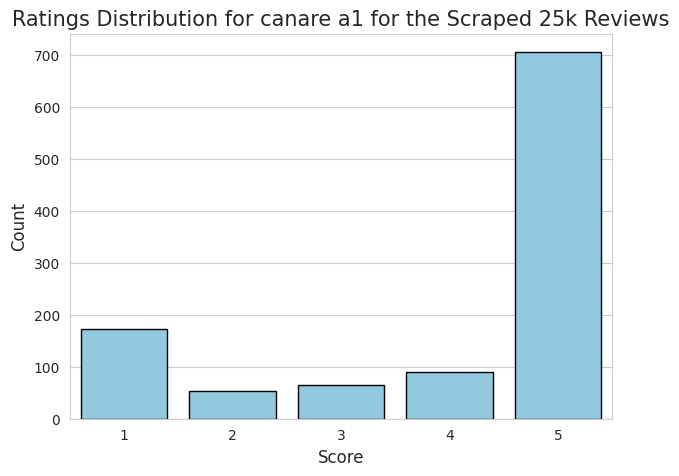

In [29]:


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize = (7,5))
sns.countplot(x='score', data=new_df, color='skyblue', edgecolor='black')
plt.title('Ratings Distribution for canare a1 for the Scraped 25k Reviews', fontsize=15)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [31]:
import pandas as pd # Import pandas for datetime handling

new_df['at'] = pd.to_datetime(new_df['at'], errors='coerce') # Convert 'at' column to datetime
new_df['year_month'] = new_df['at'].dt.to_period('M')
new_df = new_df[new_df['year_month'].dt.year >= 2019]
new_df_grouped = new_df.groupby('year_month')['score'].mean()

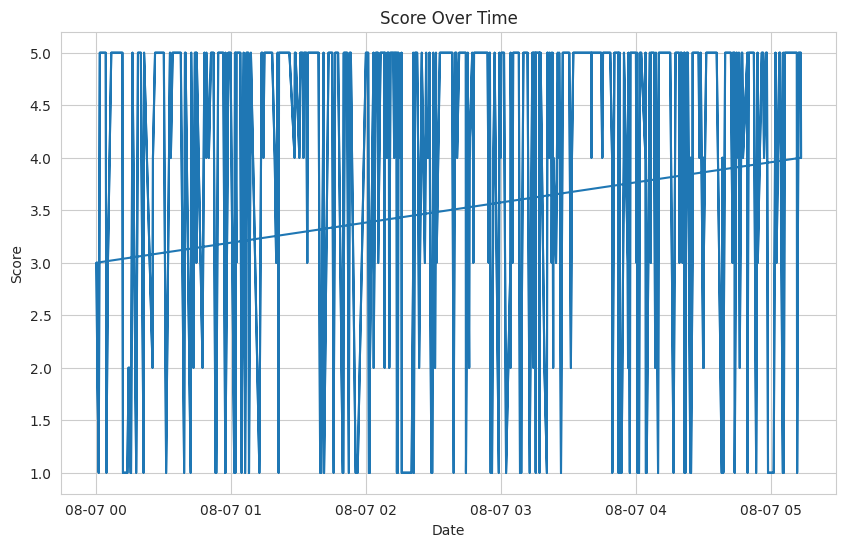

In [40]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(new_df['at'], new_df['score'])  # Plot 'score' against 'at'
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Score Over Time')
plt.grid(True)
plt.show()

In [43]:
# prompt: i want to limit my date and score  the date is refer as at here

# Assuming you want to filter data within a specific date range
start_date = '2022-01-01'  # Replace with your desired start date
end_date = '2022-12-31'    # Replace with your desired end date

# Convert dates to datetime objects for comparison
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
filtered_df = new_df[(new_df['at'] >= start_date) & (new_df['at'] <= end_date)]

# Display the filtered DataFrame
print(filtered_df)


Empty DataFrame
Columns: [reviewId, userName, content, score, thumbsUpCount, reviewCreatedVersion, at, appVersion, year_month]
Index: []


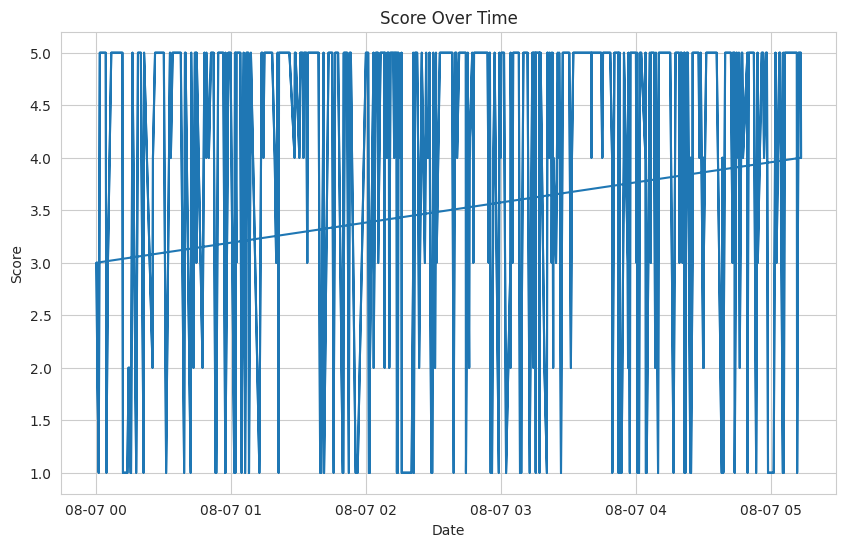

In [46]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(new_df['at'], new_df['score'])  # Plot 'score' against 'at'
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Score Over Time')
plt.grid(True)
plt.show()